In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import numpy as np
import matplotlib
import sys

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import plotly.express as px
import plotly.graph_objects as go
#from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
#import plotly.graph_objs as go
import plotly.io as pio

In [5]:
# Tell plotly to show plots inside our notebook
#init_notebook_mode(connected=True)
pio.renderers.default = "browser"

In [6]:
figure = go.Figure(go.Scatter(
        x=[1,2,3,4,5], 
        y=[2,5,1,3,4]))

figure.update_layout(
    title={
     "text":"Plot Title",
        "y":0.9,
        "x":0.5,
    })

figure.show()
print(figure)

Figure({
    'data': [{'type': 'scatter', 'x': [1, 2, 3, 4, 5], 'y': [2, 5, 1, 3, 4]}],
    'layout': {'template': '...', 'title': {'text': 'Plot Title', 'x': 0.5, 'y': 0.9}}
})


In [7]:
# Load our data from file
LocationAllData = "../data-cleanup/merged-cleaned-csv/driving_data_merged_1_to_24.csv"
df = pd.read_csv(LocationAllData)

In [8]:
# Create a new column which assigns each row to a specific distance window.
# The values in each window are averaged later on

# Decide which distance interval to average over
distanceWindowWidth = 50


def assignDistanceWindow(distance):
    distanceWindowIndex = round(distance/distanceWindowWidth)
    return distanceWindowWidth * distanceWindowIndex


# Add a new row which containts which distance group each row belongs to
df["distanceWindow"] = df["distanceTraveled"].apply(assignDistanceWindow)

How to apply multiple functions at once to a grouped data frame. In our case we want both the mean and standard deviation!
https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html#applying-multiple-functions-at-once

In [9]:
# extract the data we need into a new data frame
needed_data = df[["Attempt nr", "evisID", "userID", "distanceWindow",
                  "speed", "currentStateOfCharge", "yPosition"]].copy()

# Individual user based calculations

# Group the data based on attempt, which EVIS and userID
# Set as_index to false to allow access to these values later on for plotting
groups = needed_data.groupby(
    ["Attempt nr", "evisID", "userID", "distanceWindow"], as_index=False)

# Compute mean values for each user in each group and store in a new dataframe. This computes only the mean of given columns
average_individual = groups[[
    "speed", "currentStateOfCharge", "yPosition"]].mean().copy()
# Create a group object again from the dataframe to allow for easy itteration when plotting
average_individual_grouped = average_individual.groupby(
    ["Attempt nr", "evisID", "userID"])


# Group based calculations

average_group_based = average_individual.copy()
# Group based on each distance window for each attempt and which EVIS used
average_group_based_grouped = average_group_based.groupby(
    ["Attempt nr", "evisID", "distanceWindow"], as_index=False)
# Calculate the mean and standard deviation for each group group
# Agg is used to apply multiple functions at once!
average_group_based = average_group_based_grouped[["speed", "currentStateOfCharge", "yPosition"]].agg(
    {"speed": ["mean", "std"], "currentStateOfCharge": ["mean", "std"], "yPosition": "mean"})

average_group_based.columns = ["Attempt nr", "evisID", "distanceWindow", "speed mean", "speed std",
                               "currentStateOfCharge mean", "currentStateOfCharge std",
                               "yPosition"]

average_group_based.reindex(columns=sorted(average_group_based.columns))

# Finally re-group them based on how we want to plot group based mean
average_group_based_grouped = average_group_based.groupby(
    ["Attempt nr", "evisID"])

# Average road height calc

# Create a copy of the data we need from the group based calculations
average_road_height = average_group_based[[
    "distanceWindow", "yPosition"]].copy()
# Group by just the distance window and calculate the mean of the yPosition
average_road_height = average_road_height.groupby(
    ["distanceWindow"], as_index=False).mean()
# Rename yPosition to road height for our convenience
average_road_height = average_road_height.rename(
    columns={"yPosition": "roadHeight"})
# No need to create a new group since it's just one line to plot for the entire data frame

# average_group_based

In [10]:
whichAttempt = 2
colorGuessOMeter = "lightcoral"
colorDiffCOPE1 = "honeydew"

def plotIndividualAttempt(group, color, name):
    #return go.Scatter(x=group["distanceWindow"], y=group["speed"], 
     #                 name=str(group["userID"].iloc[-1]),
     #                 line=dict(color=color))
     return [
         go.Scatter(x=group["distanceWindow"], y=group["speed"], 
                      name=str(group["userID"].iloc[-1]),
                      line=dict(color=color)),
         #go.Scatter(x=[group["distanceWindow"].iloc[-1]], y=[group["speed"].iloc[-1]])
     ]


first_attempt_data = average_individual[average_individual["Attempt nr"] == 1]
second_attempt_data = average_individual[average_individual["Attempt nr"] == 2]

plots = []
for name, group in average_individual_grouped:
    if name[0] == whichAttempt and name[1] == "GuessOMeter":
        plots.extend(plotIndividualAttempt(group, colorGuessOMeter, name))
    if name[0] == whichAttempt and name[1] == "DiffAndCOPE1":
        plots.extend(plotIndividualAttempt(group, colorDiffCOPE1, name))

fig2 = go.Figure(data=plots)        

fig2.update_layout(
    autosize=True,
    #width=1500,
    #height=800
)

fig2.show()

In [11]:
# Plot window presets

plt.style.use("default")
params = {
    'font.size': 20,
    'axes.labelsize': 18,
    'axes.titlesize': 20,
    'legend.fontsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18
}
matplotlib.rcParams.update(params)

In [12]:
# Decide which attempt to plot and what colors to use

whichAttempt = 2
colorGuessOMeter = "C0"
colorDiffCOPE1 = "C1"
colorRoadHeight = "k"

In [13]:
%%capture out
# Prevent displaying of plot in this cell

fig, ax = plt.subplots(figsize=(15, 10))
ax2 = ax.twinx()

ax.set_xlabel("Distance [m]")
ax.set_ylabel("Speed [km/h]")
ax.set_title("Speed over distance traveled during attempt #" +
             str(whichAttempt))


def plotIndividualAttempt(group, color):
    ax.plot(group["distanceWindow"], group["speed"],
            color=color, zorder=1, linewidth=2, alpha=0.4)
    ax.plot(group["distanceWindow"].iloc[-1], group["speed"].iloc[-1], zorder=1, color=color, marker="o",
            markersize=10, alpha=.5)


def plotMeanWithSTD(group, color, order):
    ax.plot(group["distanceWindow"], group["speed mean"],
            color=color, zorder=order + 2, linewidth=4, alpha=1)
    ax.fill_between(group["distanceWindow"],
                    group["speed mean"] + group["speed std"],
                    group["speed mean"] - group["speed std"],
                    color=color, alpha=0.5, zorder=order)

# Plot the individual attempts as transparent lines. At the end of each attempt, plot a dot to mark it
# for name,group in average_individual_grouped:
#     if name[0] == whichAttempt and name[1] == "GuessOMeter":
#         plotIndividualAttempt(group,colorGuessOMeter)
#     if name[0] == whichAttempt and name[1] == "DiffAndCOPE1":
#         plotIndividualAttempt(group,colorDiffCOPE1)


# Plot the average for each group with std as a band
for name, group in average_group_based_grouped:
    if name[0] == whichAttempt and name[1] == "GuessOMeter":
        plotMeanWithSTD(group, colorGuessOMeter, 2)
    if name[0] == whichAttempt and name[1] == "DiffAndCOPE1":
        plotMeanWithSTD(group, colorDiffCOPE1, 3)

In [14]:
# Plot the road height averaged over all the drives
ax2.set_ylabel('Road height [m]', color=colorRoadHeight)
road_height_plot, = ax2.plot(average_road_height["distanceWindow"], average_road_height["roadHeight"], color=colorRoadHeight,
                             zorder=2, linewidth=2, linestyle="--", alpha=1, label="Road height")

## Attempt #1 for speed over distance traveled

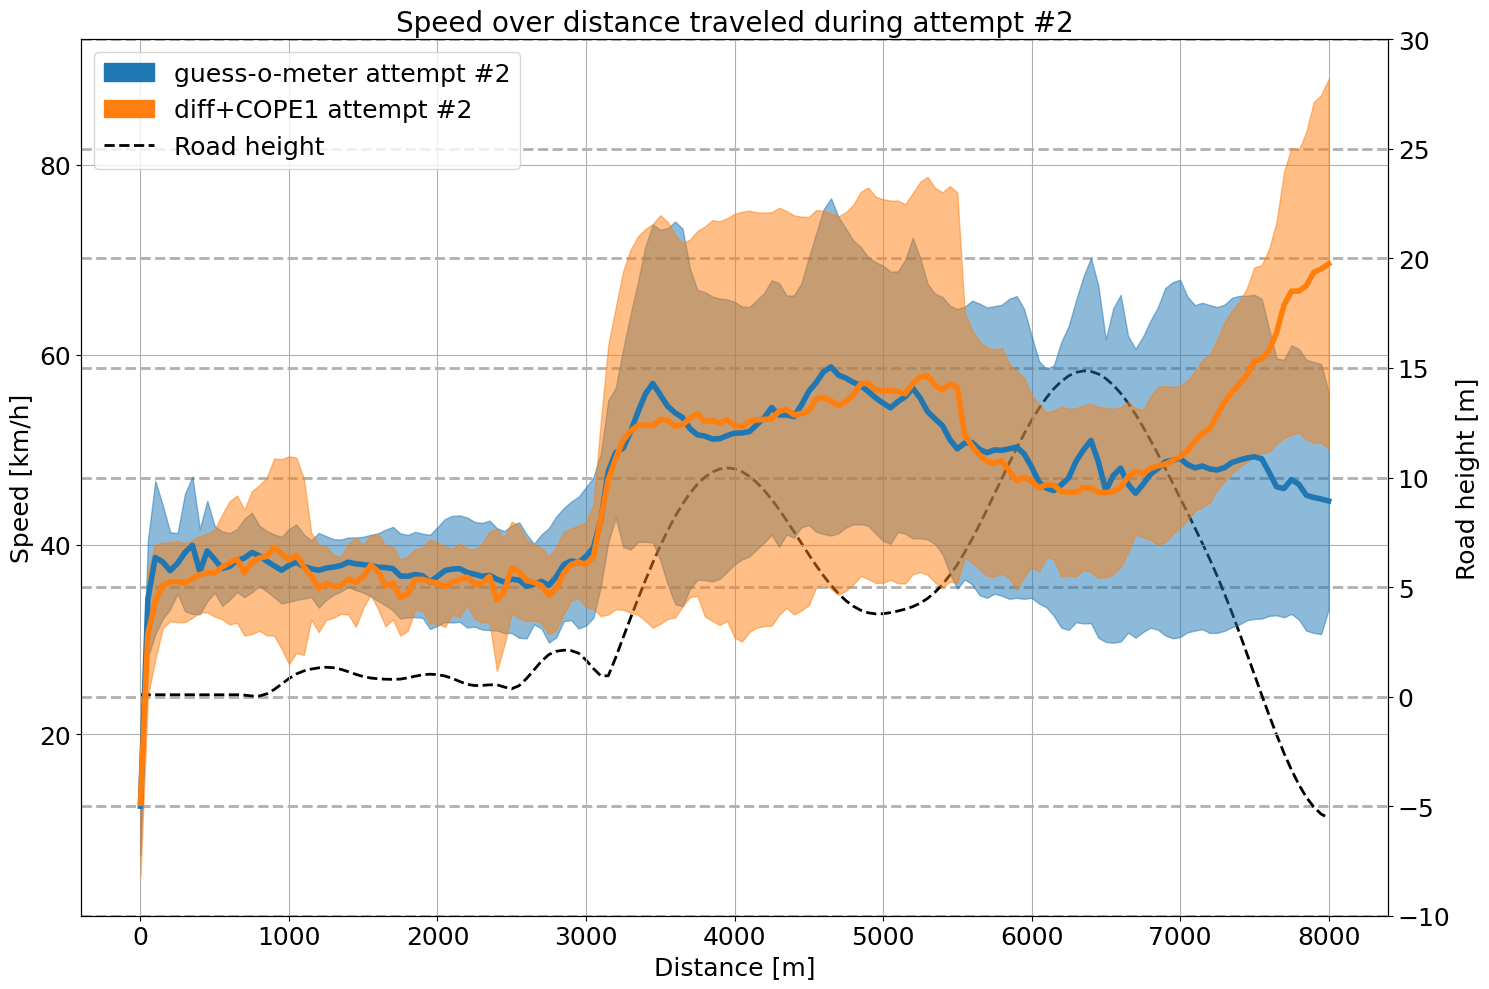

In [15]:
%matplotlib widget
# Adjustments for our plot

# Custom legend
first_patch = patches.Patch(
    color=colorGuessOMeter, label="guess-o-meter attempt #" + str(whichAttempt))
second_patch = patches.Patch(
    color=colorDiffCOPE1, label="diff+COPE1 attempt #" + str(whichAttempt))

ax.legend(handles=[first_patch, second_patch,
                   road_height_plot], loc="upper left")

# ax.set_ylim(0,100)
ax2.set_ylim(-10, 30)
# ax.set_yticks(np.arange(0,101,10))
# ax2.set_yticks(np.arange(-10,31,5))

ax.grid(True)
ax2.grid(True, linestyle="--", linewidth=2)

# Prevent secondary axis from drawing ontop of everything
ax.set_zorder(1)
ax.patch.set_visible(False)
fig.tight_layout()

fig

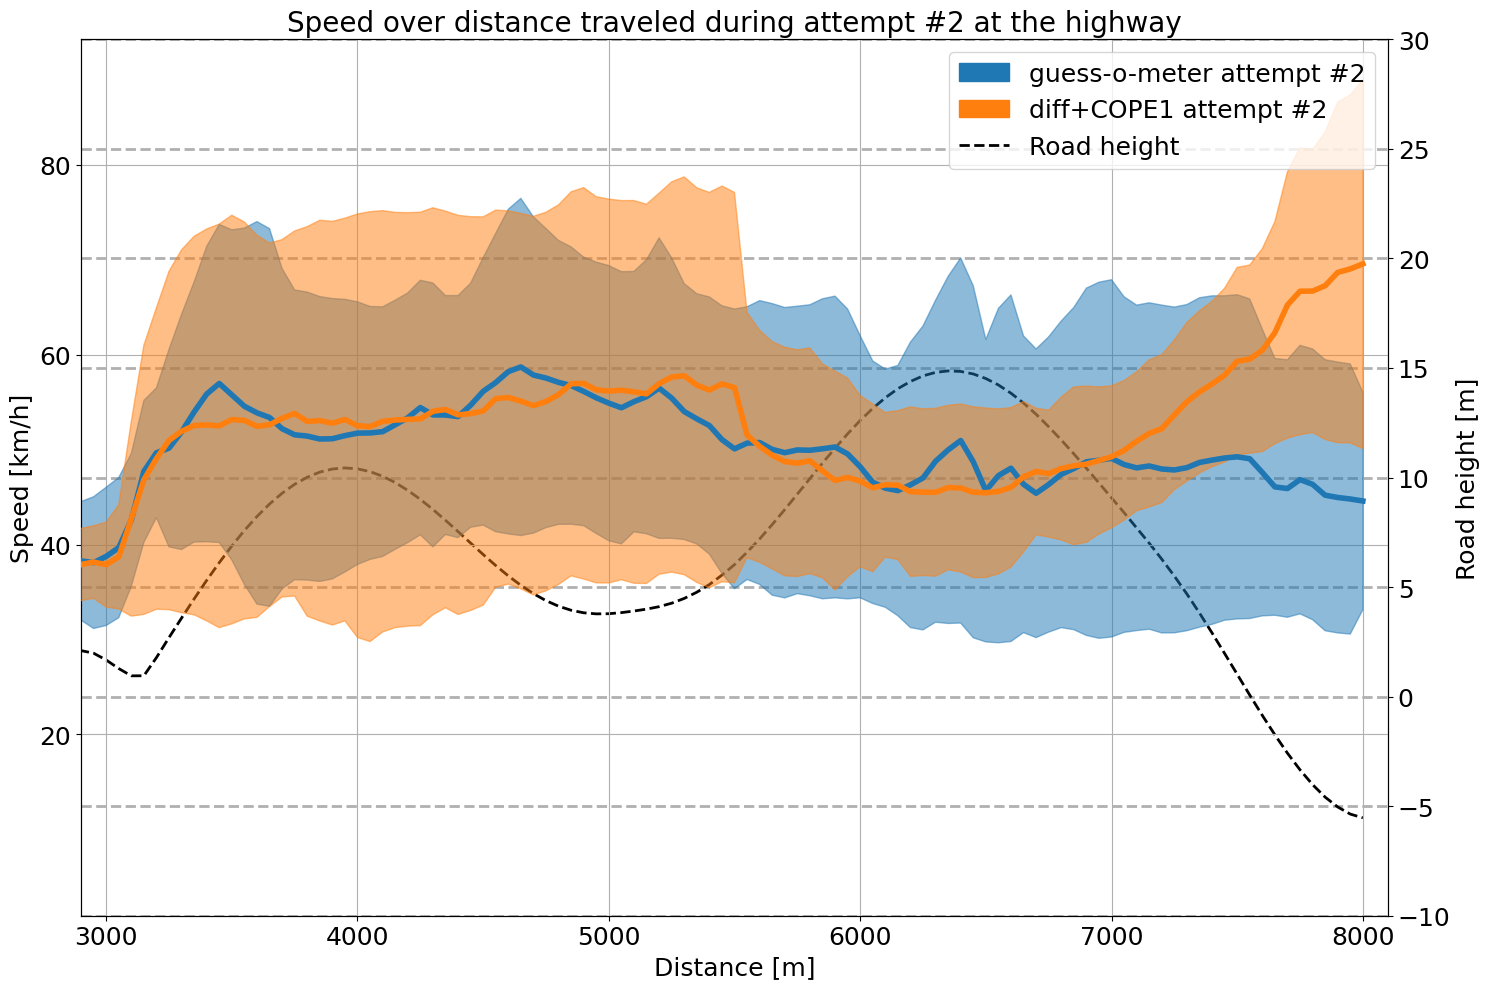

In [16]:
ax.set_title("Speed over distance traveled during attempt #" +
             str(whichAttempt) + " at the highway")
ax.set_xlim(2900, 8100)
# ax.set_ylim(30,80)

ax.legend(handles=[first_patch, second_patch,
                   road_height_plot], loc="upper right")

fig

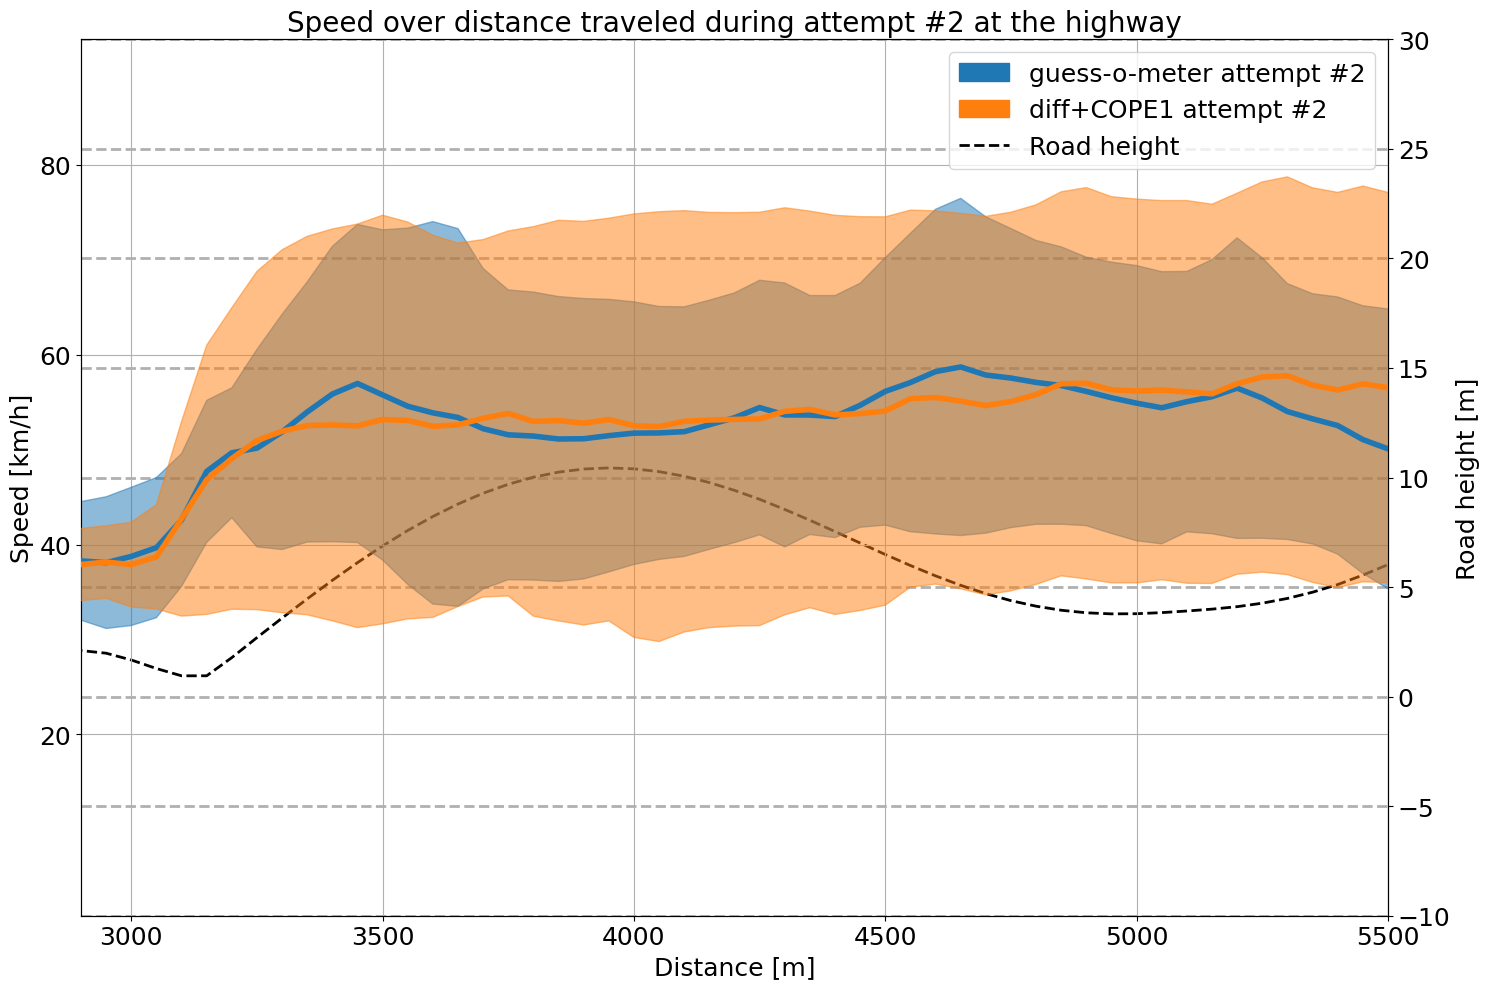

In [17]:
ax.set_title("Speed over distance traveled during attempt #" +
             str(whichAttempt) + " at the highway")
ax.set_xlim(2900, 5500)
# .set_ylim(0,100)

ax.legend(handles=[first_patch, second_patch,
                   road_height_plot], loc="upper right")

fig

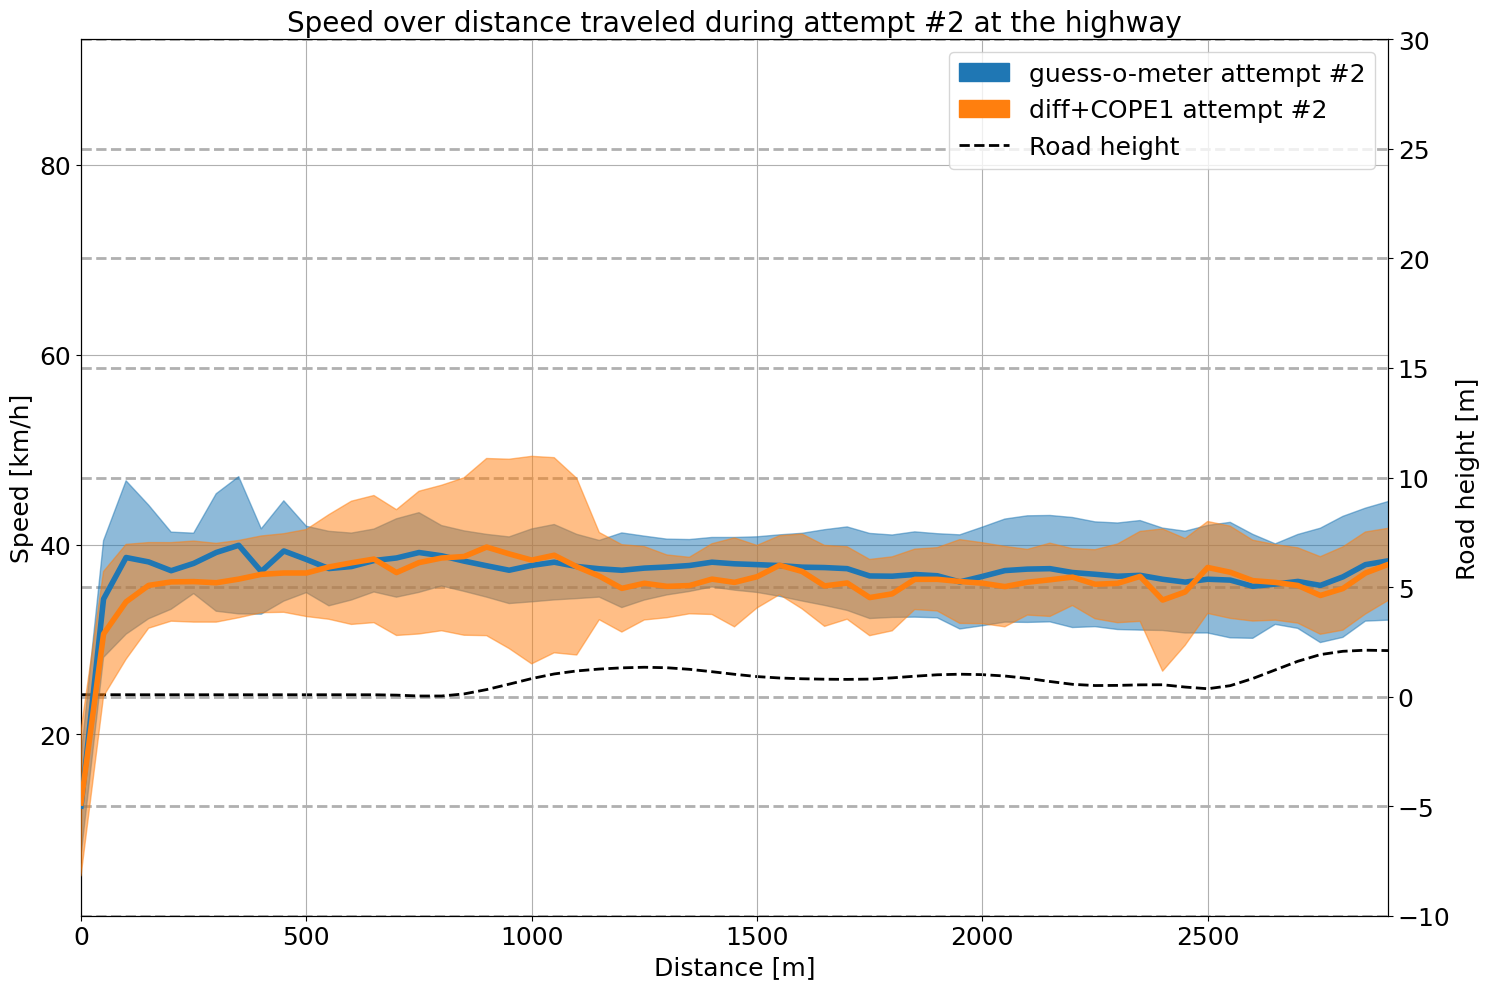

In [18]:
ax.set_title("Speed over distance traveled during attempt #" +
             str(whichAttempt) + " at the highway")
ax.set_xlim(0, 2900)
# ax.set_ylim(0,60)

ax.legend(handles=[first_patch, second_patch,
                   road_height_plot], loc="upper right")

fig